In [46]:
import pandas as pd
import os
import warnings
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from datetime import datetime
from datetime import date

warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### ========================================================

In [2]:
test_0909_uni_test = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                'equipment_dict','fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 
                'productionDate', 'vehicleTransmission', 'vendor', 
                'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']
test_0909_uni_0909 = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                 'Комплектация','fuelType', 'mileage', 'modelDate', 'model', 'numberOfDoors', 
                'productionDate', 'vehicleTransmission', 
                'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'price']

### ========================================================

In [3]:
test = pd.read_csv('./Project_7_data/test.csv',low_memory=False)
df= pd.read_csv('./Project_7_data/' + 'auto_ru_2020_09_09.csv',low_memory=False)

In [4]:
df_full= pd.read_csv('./Preproject_7_data/' + 'all_auto_ru_09_09_2020.csv',low_memory=False)

### ===================0909=================================

In [5]:
def bodyType_unification(x):
    res=[]
    x = x.lower() if type(x) == str else x  # <================
    try:
        for body_type in test.bodyType.unique():
            if body_type in x:
                res.append(body_type)
    except Exception: return x
    if not res: 
        return x.split()[0]
    return max(res)

def engineDisplacement_unification(x):
    x = float(re.sub("[^\d.]", r'', x)) if re.sub("[^\d.]", r'', x) else 0
    if x >= 7: x = 0
    return x

def train_options(x):
    point = "'available_options': "
    start = x.find(point)+len(point)+2
    finish = x.find("]",start) - 1
    return x[start:finish].split("', '")

def test_ownership_unification(x):
    try:
        digits = re.findall('\d+',x) 
        if len(digits) == 2: res = int(digits[0])*12 + int(digits[1])
        elif len(digits) == 1 and 'месяц' in x: res = int(digits[0])
        elif len(digits) == 1 and 'месяц' not in x: res = int(digits[0])*12
    except Exception: res = 0   
    return res

def train_ownership_unification(x):
    tmp = json.loads(x.replace("'",'"'))  if x==x else {'year': 2020, 'month': 9}
    res = (2020 - tmp['year'])*12 + tmp['month'] - 9
    if res<0: res = 0
    return res


In [6]:
def test_unification(df_to_proc):
    test = df_to_proc.copy()[test_0909_uni_test]
    owner_dict = {'3 или более': 3., '2\xa0владельца': 2.,'1\xa0владелец': 1.}
    # engineDisplacement
    test.engineDisplacement = test.engineDisplacement.apply(
        lambda x: float(x[:-4]) if x[:-4] else np.NaN) 
    # enginePower
    test.enginePower = test.enginePower.apply(lambda x: int(x[:-4]))
    # equipment_dict
    test.equipment_dict = test.equipment_dict.apply(
        lambda x: list(json.loads(x).keys()) if x==x else [])
    # Владельцы
    test.Владельцы = test.Владельцы.map(owner_dict)
    # Владение
    test.Владение = test.Владение.apply(test_ownership_unification)
    return test

In [7]:
def train_0909_unification(df_to_proc):
    df = df_to_proc.copy()[test_0909_uni_0909]
    color_codes = {'040001': 'чёрный','FAFBFB': 'белый', '0000CC': 'синий', 
                   '200204': 'коричневый', 'EE1D19': 'красный', 'CACECB': 'серый',
                   'C49648': 'бежевый', '97948F': 'серебристый', 'FFD600': 'жёлтый',
                   'FF8649': 'оранжевый', '22A0F8': 'голубой','FFC0CB': 'розовый', 
                   'DEA522': 'золотистый', '007F00': 'зелёный', '660099': 'пурпурный',
                   '4A2197': 'фиолетовый'}
    transmission_dict = {'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 
                         'ROBOT':'роботизированная','VARIATOR':'вариатор'}
    vendor_dict = {'AUDI':'EUROPEAN','BMW':'EUROPEAN','HONDA':'JAPANESE','INFINITI':'JAPANESE',
                   'LEXUS':'JAPANESE','MERCEDES':'EUROPEAN','MITSUBISHI':'JAPANESE',
                   'NISSAN':'JAPANESE','SKODA':'EUROPEAN','TOYOTA':'JAPANESE',
                   'VOLKSWAGEN':'EUROPEAN','VOLVO':'EUROPEAN'}
    PTS_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
    wheel_dict = {'LEFT':'Левый', 'RIGHT':'Правый'}
    # bodyType
    df.dropna(subset=['bodyType'],inplace=True)
    df.bodyType = df.bodyType.apply(bodyType_unification)
    # color
    df.color = df.color.map(color_codes)
    # engineDisplacement
    df.engineDisplacement = df.engineDisplacement.apply(engineDisplacement_unification)
    # enginePower
    df.enginePower = df.enginePower.astype(int)
    # equipment_dict
    df['equipment_dict'] = df.Комплектация.apply(train_options)
    df.drop(columns=['Комплектация'],inplace=True)
    # modelDate 
    df.modelDate = df.modelDate.astype(int)
    # model_name
    df['model_name'] = df.model
    df.drop(columns=['model'],inplace=True)
    # numberOfDoors
    df.numberOfDoors = df.numberOfDoors.astype(int)
    # vehicleTransmission
    df.vehicleTransmission = df.vehicleTransmission.map(transmission_dict)
    # vendor
    df['vendor'] = df.brand.map(vendor_dict)
    # Владение
    df.Владение = df.Владение.apply(train_ownership_unification)
    # ПТС
    df.ПТС = df.ПТС.map(PTS_dict)
    # Руль
    df.Руль = df.Руль.map(wheel_dict)
    
    return df

In [8]:
%%time 
test_uni = test_unification(test)

Wall time: 404 ms


In [9]:
%%time
train_0909_uni = train_0909_unification(df)

Wall time: 1min 34s


In [10]:
%%time
train_0909_full_uni = train_0909_unification(df_full)

Wall time: 2min 43s


## =================PARS===========================

In [11]:
pars = pd.read_csv('./Project_7_data/train_new.csv')
test = pd.read_csv('./Project_7_data/test.csv',low_memory=False)

In [12]:
test_pars_uni = ['model_name', 'equipment_dict', 'brand', 'modelDate', 
                 'productionDate', 'ПТС','mileage', 'car_url', 'engineDisplacement', 
                 'numberOfDoors', 'enginePower', 'vendor', 'color', 'vehicleTransmission', 
                 'sell_id', 'Владельцы', 'Руль', 'bodyType', 'Привод']

In [13]:
def test_pars_uniifcation(df_to_proc):
    test = df_to_proc.copy()[test_pars_uni] # <===== ПОСТАВИТЬ СПИСОК КОЛОНОК
    # engineDisplacement
    test.engineDisplacement = test.engineDisplacement.apply(
        lambda x: float(x[:-4]) if x[:-4] else np.NaN)
    # modelDate
    test.modelDate = test.modelDate.astype(float)
    # productionDate
    test.productionDate = test.productionDate.astype(float)
    # numberOfDoors
    test.numberOfDoors = test.numberOfDoors.astype(float)
    # Владельцы
    owner_dict = {
        '3 или более': 3., 
        '2\xa0владельца': 2.,
        '1\xa0владелец': 1.}
    test.Владельцы = test.Владельцы.map(owner_dict)
    # mileage
    test.mileage = test.mileage.astype(float) 
    # enginePower
    test.enginePower = test.enginePower.apply(lambda x: float(x[:-4]))
    # equipment_dic
    test.equipment_dict = test.equipment_dict.apply(
        lambda x: list(json.loads(x).keys()) if x==x else [])
    
    return test

In [14]:
def pars_unification(df_to_proc):
    pars = df_to_proc.copy()[test_pars_uni] # <===== ПОСТАВИТЬ СПИСОК КОЛОНОК
    # modelDate
    model_generation_year = pd.read_csv(".\Project_7_data\model_generation_year.csv")
    model_generation_year = dict(zip(model_generation_year.full_name + ' ' + model_generation_year.bodytype,
             model_generation_year.generation_year))
#     pars.modelDate = (pars.modelDate + ' ' + pars.bodyType).map(model_generation_year) 
    pars.modelDate = pd.Series(
        [x+' '+y if x==x else x for x,y in zip(pars.modelDate,pars.bodyType)]).\
        map(model_generation_year)
    # Владельцы
    owner_dict = {
        '3 или более': 3., 
        '2\xa0владельца': 2.,
        '1\xa0владелец': 1.}
    pars.Владельцы = test.Владельцы.map(owner_dict)
    # equipment_dic
    pars.equipment_dict = pars.equipment_dict[:50].apply(
        lambda x: pd.Series(list(json.loads(x.replace("'",'"')).values())).sum()
        if x==x else x)    
    
    return pars

In [15]:
pars_unification(pars)[:2]

,model_name,equipment_dict,brand,modelDate,productionDate,ПТС,mileage,car_url,engineDisplacement,numberOfDoors,enginePower,vendor,color,vehicleTransmission,sell_id,Владельцы,Руль,bodyType,Привод
0,Fabia,"[Подушка безопасности водителя, Подушка безопа...",SKODA,2010.0,2014.0,Оригинал,121000.0,https://auto.ru/cars/used/sale/skoda/fabia/111...,1.4,5.0,86.0,EUROPEAN,белый,механическая,1114778882,3.0,Левый,хэтчбек 5 дв.,передний
1,Fabia,"[Подушка безопасности водителя, Подушка безопа...",SKODA,2010.0,2012.0,Оригинал,108980.0,https://auto.ru/cars/used/sale/skoda/fabia/111...,1.2,5.0,105.0,EUROPEAN,красный,роботизированная,1114779535,1.0,Левый,хэтчбек 5 дв.,передний
2,Fabia,"[Подушка безопасности водителя, Подушка безопа...",SKODA,2010.0,2014.0,Оригинал,121000.0,https://auto.ru/cars/used/sale/skoda/fabia/111...,1.4,5.0,86.0,EUROPEAN,белый,механическая,1114778882,1.0,Левый,хэтчбек 5 дв.,передний
3,Fabia,NaN,SKODA,2010.0,2012.0,Оригинал,122000.0,https://auto.ru/cars/used/sale/skoda/fabia/110...,1.2,5.0,70.0,EUROPEAN,серый,механическая,1105645244,1.0,Левый,хэтчбек 5 дв.,передний
4,Fabia,"[Антипробуксовочная система (ASR), Антиблокиро...",SKODA,2010.0,2013.0,Оригинал,8766.0,https://auto.ru/cars/used/sale/skoda/fabia/111...,1.4,5.0,86.0,EUROPEAN,синий,механическая,1114915329,1.0,Левый,хэтчбек 5 дв.,передний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,Space Wagon,NaN,MITSUBISHI,1998.0,2002.0,Дубликат,255580.0,https://auto.ru/cars/used/sale/mitsubishi/spac...,2.4,NaN,147.0,JAPANESE,чёрный,автоматическая,1114836872,3.0,Левый,компактвэн,передний
23217,Space Wagon,NaN,MITSUBISHI,1998.0,2001.0,Оригинал,260000.0,https://auto.ru/cars/used/sale/mitsubishi/spac...,2.4,NaN,147.0,JAPANESE,синий,автоматическая,1106080477,2.0,Левый,компактвэн,передний
23218,Space Wagon,NaN,MITSUBISHI,1992.0,1996.0,Оригинал,271000.0,https://auto.ru/cars/used/sale/mitsubishi/spac...,2.0,NaN,82.0,JAPANESE,синий,механическая,1105252560,1.0,Левый,компактвэн,передний
23219,Space Wagon,NaN,MITSUBISHI,1998.0,1998.0,Оригинал,250000.0,https://auto.ru/cars/used/sale/mitsubishi/spac...,2.4,NaN,150.0,JAPANESE,фиолетовый,автоматическая,1114812281,1.0,Левый,компактвэн,передний


In [16]:
test_pars_uniifcation(test)[:2]

,model_name,equipment_dict,brand,modelDate,productionDate,ПТС,mileage,car_url,engineDisplacement,numberOfDoors,enginePower,vendor,color,vehicleTransmission,sell_id,Владельцы,Руль,bodyType,Привод
0,OCTAVIA,"[engine-proof, tinted-glass, airbag-driver, au...",SKODA,2013.0,2014.0,Оригинал,74000.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,1.2,5.0,105.0,EUROPEAN,синий,роботизированная,1100575026,3.0,Левый,лифтбек,передний
1,OCTAVIA,"[cruise-control, asr, esp, airbag-driver, isof...",SKODA,2017.0,2017.0,Оригинал,60563.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,1.6,5.0,110.0,EUROPEAN,чёрный,механическая,1100549428,1.0,Левый,лифтбек,передний
2,SUPERB,"[cruise-control, tinted-glass, esp, adaptive-l...",SKODA,2013.0,2014.0,Оригинал,88000.0,https://auto.ru/cars/used/sale/skoda/superb/11...,1.8,5.0,152.0,EUROPEAN,серый,роботизированная,1100658222,1.0,Левый,лифтбек,передний
3,OCTAVIA,"[cruise-control, roller-blind-for-rear-window,...",SKODA,2013.0,2014.0,Оригинал,95000.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,1.6,5.0,110.0,EUROPEAN,коричневый,автоматическая,1100937408,1.0,Левый,лифтбек,передний
4,OCTAVIA,"[cruise-control, asr, esp, airbag-driver, isof...",SKODA,2008.0,2012.0,Оригинал,58536.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,1.8,5.0,152.0,EUROPEAN,белый,автоматическая,1101037972,1.0,Левый,лифтбек,передний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,3ER,"[cruise-control, asr, tinted-glass, esp, start...",BMW,2011.0,2014.0,Оригинал,115000.0,https://auto.ru/cars/used/sale/bmw/3er/1101369...,1.6,4.0,136.0,EUROPEAN,коричневый,автоматическая,1101369263,3.0,Левый,седан,задний
34682,5ER,[],BMW,2016.0,2018.0,Оригинал,98000.0,https://auto.ru/cars/used/sale/bmw/5er/1101369...,2.0,4.0,190.0,EUROPEAN,чёрный,автоматическая,1101369581,1.0,Левый,седан,полный
34683,5ER,[],BMW,1995.0,1997.0,Дубликат,360000.0,https://auto.ru/cars/used/sale/bmw/5er/1101364...,2.5,4.0,170.0,EUROPEAN,серый,автоматическая,1101364889,3.0,Левый,седан,задний
34684,X1,"[engine-proof, esp, start-stop-function, airba...",BMW,2012.0,2013.0,Оригинал,90500.0,https://auto.ru/cars/used/sale/bmw/x1/11013625...,2.0,5.0,184.0,EUROPEAN,коричневый,автоматическая,1101362518,2.0,Левый,внедорожник 5 дв.,полный


## =============== ПРОПУСКИ =================
# Оработка пропусков
Займеся пропусками в приведенных к единому виду test и train
## Пропуски в train
Сначала посмотирм на количество прпусков в колонках:

In [23]:
train_0909_full_uni.isna().sum()[train_0909_full_uni.isna().sum()>0]

Владельцы    13588
ПТС            361
price          410
vendor       40069
dtype: int64

In [ ]:
train_0909_uni.isna().sum()[train_0909_uni.isna().sum()>0]

Во первых обратим внимание на пропуски в `price` - наблюдения с пропуском в целевой переменной нам не нужны поэтому удаляем их.

In [37]:
train_0909_full_uni.dropna(subset=['price'],inplace=True)

In [38]:
train_0909_full_uni.isna().sum()[train_0909_full_uni.isna().sum()>0]

Владельцы    13569
ПТС            361
vendor       39867
dtype: int64

Большая часть пропусков в колонках `vendor` и `Владельцы` , относительно небольшой количесвто пропусков `ПТС`. Рассмотрим каждую колонку отдельно.

### Владельцы

In [42]:
train_0909_full_uni.Владельцы.value_counts(dropna=False)

3.0    36098
2.0    20902
1.0    18398
NaN    13569
Name: Владельцы, dtype: int64

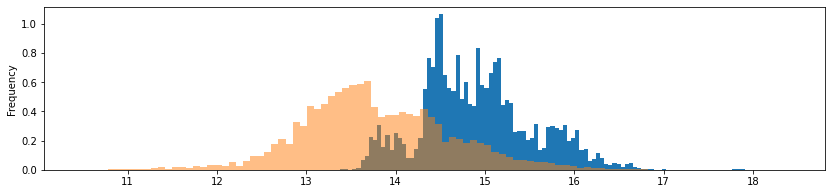

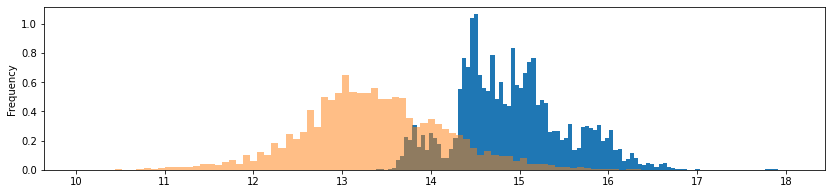

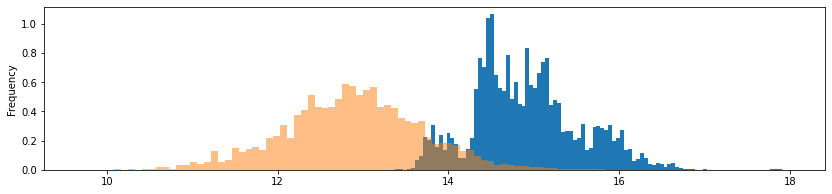

In [65]:
# plt.figure(figsize=(14,3))
# log(train_0909_full_uni.price).plot.hist(bins=100,density=True)
plt.figure(figsize=(14,3))
log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 1]).plot.hist(
    bins=100,density=True,alpha = 0.5)
plt.figure(figsize=(14,3))
log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 2]).plot.hist(
    bins=100,density=True,alpha = 0.5)
plt.figure(figsize=(14,3))
log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 3]).plot.hist(
    bins=100,density=True,alpha = 0.5)

Ночего пхожего. Применимдля заполнеия пропусков предсказание модели, обученой на нашм датасете, с целевой переменной  - `Владельцы`. В качестве моденли возьмем catboost с дефолтными параметрами. В качестве обучающей выьорки возьмем те признки из даатасета, котроый можно применить без сложной обрабтки.

In [ ]:
model

In [34]:
train_0909_full_uni.brand[train_0909_full_uni.vendor.isna()].unique()

array(['CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG'], dtype=object)

In [40]:
test_uni.isna().sum()[test_uni.isna().sum()>0]

engineDisplacement    55
ПТС                    1
dtype: int64

## ===================EDA========================

## ==============BASELINE EXTENSE===============

# ПОДВАЛ

In [64]:
ticket_url = 'https://auto.ru/moskva/cars/toyota/land_cruiser_prado/used/'
brand = 'TOYOTA'

# brand = features['brand']
model_name_start = ticket_url.find(brand.lower()) + len(brand) + 1
model_name_end = ticket_url.find('/',model_name_start)
ticket_url[model_name_start:model_name_end].upper()

#### car_url

print(test.car_url[5]),print(pars.car_url[5]);

#### engineDisplacement

test.engineDisplacement.apply(
    lambda x: float(x[:-4]) if x[:-4] else np.NaN).unique()

pars.engineDisplacement.unique()

#### vehicleTransmission

test.vehicleTransmission.unique() ,pars.vehicleTransmission.unique()

#### Руль

test.Руль.unique(),pars.Руль.unique()

#### sell_id

test.sell_id[0],pars.sell_id[0]

#### modelDate

test.modelDate = test.modelDate.astype(float)
test.modelDate.unique()

model_generation_year = pd.read_csv(".\Project_7_data\model_generation_year.csv")
model_generation_year = dict(zip(model_generation_year.full_name + ' ' + model_generation_year.bodytype,
         model_generation_year.generation_year))
pars.modelDate = (pars.modelDate + ' ' + pars.bodyType).map(model_generation_year)

pars.modelDate.unique()

#### color

set(pars.color.unique()) - set(test.color.unique())

#### Привод

test.Привод.unique(),pars.Привод.unique()

#### productionDate

test.productionDate = test.productionDate.astype(float)
test.productionDate[:5]

pars.productionDate[:5]

#### numberOfDoors

test.numberOfDoors = test.numberOfDoors.astype(float)
test.numberOfDoors.unique()

pars.numberOfDoors.unique()

#### vendor

test.vendor.unique(), pars.vendor.unique()

#### Владельцы

owner_dict = {
    '3 или более': 3., 
    '2\xa0владельца': 2.,
    '1\xa0владелец': 1.
}
test.Владельцы = test.Владельцы.map(owner_dict)
pars.Владельцы = pars.Владельцы.map(owner_dict)

test.Владельцы.unique(), pars.Владельцы.unique()

#### mileage

test.mileage = test.mileage.astype(float)
test.mileage.unique()

pars.mileage.unique()

#### enginePower

test.enginePower.isna().sum()

test.enginePower = test.enginePower.apply(lambda x: int(x[:-4])).astype(float)
test.enginePower.unique()

pars.enginePower.unique()[:5]

#### model_name

test.model_name.unique()[:30]

pars.model_name.unique()[:5]

#### ПТС

test.ПТС.unique(), pars.ПТС.unique()

#### bodyType

set(test.bodyType.unique()) - set(pars.bodyType.unique())

#### equipment_dict

test.equipment_dict = test.equipment_dict.apply(lambda x: list(json.loads(x).keys()) if x==x else [])

pars.equipment_dict = pars.equipment_dict[:50].apply(
    lambda x: pd.Series(list(json.loads(x.replace("'",'"')).values())).sum()
    if x==x else x)



test.equipment_dict[0][:2],pars.equipment_dict[0][:2]

#### 'description'

test.description[0]

# pars.description[0]

#### brand

test.brand.unique()

pars.brand.unique()

#### offerprice

pars.offerprice